# 1. Выбор и преобразование данных для анализа

Подключаю необходимые библиотеки

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, plotly.express as px
from sklearn import tree,ensemble,model_selection,metrics,neighbors
from warnings import filterwarnings as fw
fw('ignore')

Преобразую тестовую и тренировочную выборки: уберу незначащие столбцы, а также преобразую пол в набор бинарных значений. Оставил столбцы Класс обслуживания, Возраст, Цена за билет и Пол (в тренировочной еще бинарный набор выжил/невыжил).

In [3]:
data = pd.read_csv('train.csv')
#data.head()
data=data.drop(columns=['PassengerId','Name','Parch','Ticket','Cabin','Embarked','SibSp']);
#data_train.head()
data['sex1']=np.where(data['Sex']=="male",0,1)
data=data.drop(columns='Sex')
data.head()

,Survived,Pclass,Age,Fare,sex1
0,0,3,22.0,7.2500,0
1,1,1,38.0,71.2833,1
2,1,3,26.0,7.9250,1
3,1,1,35.0,53.1000,1
4,0,3,35.0,8.0500,0


Отберем в отдельные датафреймы характеристики объектов и метки классов.
Затем поделим датасет на обучающую и тестовую выборки в классическом соотношении 1:4.

In [4]:
data=data.dropna()
x = data.iloc[:,1:]
y = data.iloc[:,:1]
xtrain,xtest,ytrain,ytest = model_selection.train_test_split(x,y,test_size=0.2)
print('xtrain: ', xtrain.shape, 'ytrain: ', ytrain.shape, '\nxtest: ', xtest.shape, 'ytest: ', ytest.shape)
ytest=ytest.to_numpy().flatten()

xtrain:  (571, 4) ytrain:  (571, 1) 
xtest:  (143, 4) ytest:  (143, 1)


In [5]:
print(y.shape)

(714, 1)


Проверю наличие NaN для дальнейшей корректной обработки.

In [6]:
for i in data.columns:
    print(data[i].isnull().value_counts())

False    714
Name: Survived, dtype: int64
False    714
Name: Pclass, dtype: int64
False    714
Name: Age, dtype: int64
False    714
Name: Fare, dtype: int64
False    714
Name: sex1, dtype: int64


# 2. Построение модели DecisionTreeClassifier и исследование влияния параметров на качество классификации

In [7]:
DTC = tree.DecisionTreeClassifier()
DTC.fit(xtrain,ytrain)
ypred = DTC.predict(xtest)
print(metrics.classification_report(ytest,ypred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,DTC.predict_proba(xtest)[:,1],average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           0    0.67416   0.82192   0.74074        73
           1    0.75926   0.58571   0.66129        70

    accuracy                        0.70629       143
   macro avg    0.71671   0.70382   0.70102       143
weighted avg    0.71582   0.70629   0.70185       143

AUC (area under ROC curve) =  0.7096868884540117


In [8]:
for i in range(4):
    if DTC.feature_importances_[i] !=0:
        print(data.columns[i+1], ' - ', DTC.feature_importances_[i])

Pclass  -  0.13012733029712084
Age  -  0.2803439324800056
Fare  -  0.26455770068115575
sex1  -  0.3249710365417178


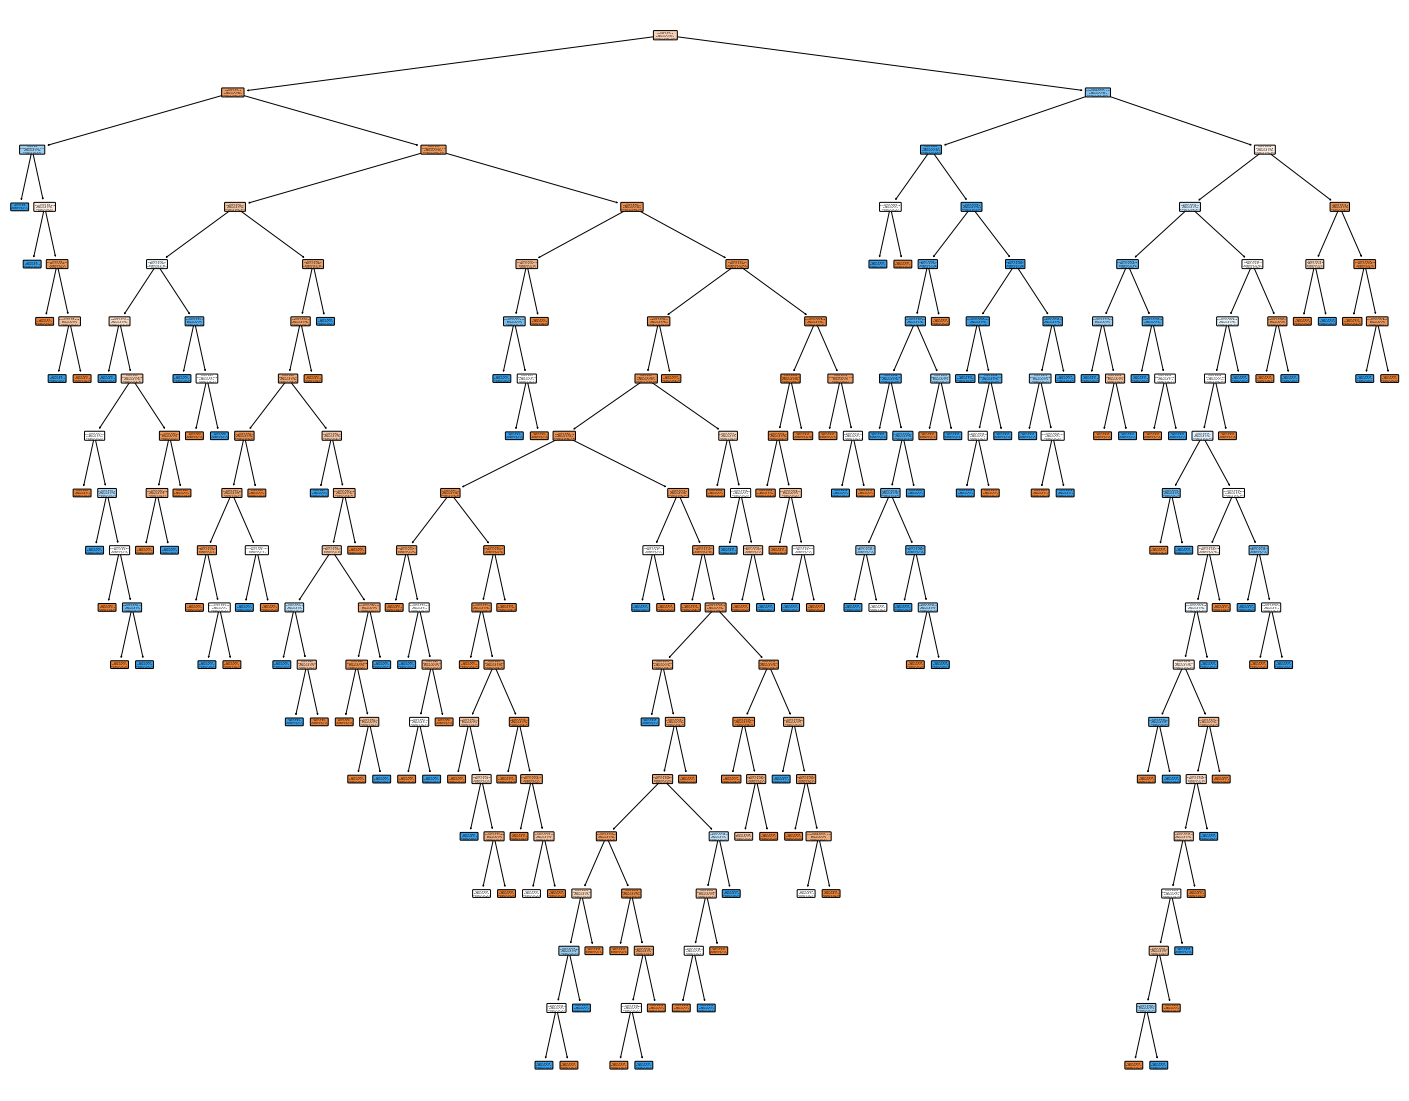

In [9]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=['PassengerId','Name','Parch','Ticket','Cabin','Embarked','SibSp'],  
                   class_names=['yes','no'],
                   filled=True,
                   rounded=True, 
                   node_ids=True)

In [10]:
print('Before boosting: ')
print(metrics.classification_report(ytest,ypred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,DTC.predict_proba(xtest)[:,1],average='macro',multi_class='ovr'))
GBC = ensemble.GradientBoostingClassifier(init=DTC)
GBC.fit(xtrain,ytrain)
GBCpred = GBC.predict(xtest)
print('After boosting: ')
print(metrics.classification_report(ytest,GBCpred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,GBC.predict_proba(xtest)[:,1],average='macro',multi_class='ovr'))

Before boosting: 
              precision    recall  f1-score   support

           0    0.67416   0.82192   0.74074        73
           1    0.75926   0.58571   0.66129        70

    accuracy                        0.70629       143
   macro avg    0.71671   0.70382   0.70102       143
weighted avg    0.71582   0.70629   0.70185       143

AUC (area under ROC curve) =  0.7096868884540117
After boosting: 
              precision    recall  f1-score   support

           0    0.68966   0.82192   0.75000        73
           1    0.76786   0.61429   0.68254        70

    accuracy                        0.72028       143
   macro avg    0.72876   0.71810   0.71627       143
weighted avg    0.72794   0.72028   0.71698       143

AUC (area under ROC curve) =  0.800587084148728
